In [1]:
!pip install PyPrind --quiet

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import tarfile
import pyprind

plt.style.use("fivethirtyeight")

# Downloading the dataset

In [3]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-01-18 11:23:29--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  18.7MB/s    in 8.5s    

2023-01-18 11:23:38 (9.40 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [4]:
with tarfile.open("./aclImdb_v1.tar.gz", 'r') as tarf:
      tarf.extractall("./")

In [5]:
!ls -lh aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train


# Transformation of data set from text reviews to csv

In [6]:
base = './aclImdb/'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()

for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(base, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()

df.columns = ['review', 'sentiment']

np.random.seed(0)

df = df.reindex(np.random.permutation(df.index))
df.to_csv('IMDb_Raw_Reviews.csv', index=False, encoding='utf-8')

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:34


In [7]:
#importing the training dataset
imdb_df=pd.read_csv('./IMDb_Raw_Reviews.csv')
print(imdb_df.shape)
imdb_df.sample(10)

(50000, 2)


,review,sentiment
28921,"An ultra-nervous old man, ""Mr. Goodrich,"" terr...",1
11971,"Please, spare me of these movies that teach us...",0
15919,"Well, the Hero and the Terror is slightly belo...",0
6271,"That's how Burt Reynolds describes this film, ...",1
11435,"Alfred Hitchcock's ""Saboteur"" (1942) (not to b...",1
34200,"Now for sure, this is one of the lightest-hear...",1
40991,"This isn't exactly a great film, but I admire ...",1
20155,This dreadful film assembles every Asian stere...,0
2648,"I confess--Emma, in my opinion, is the single ...",0
34013,The movie was very good. I'm an avid mystery f...,1


**Sentiment count**

In [8]:
imdb_df.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

**Missing values**

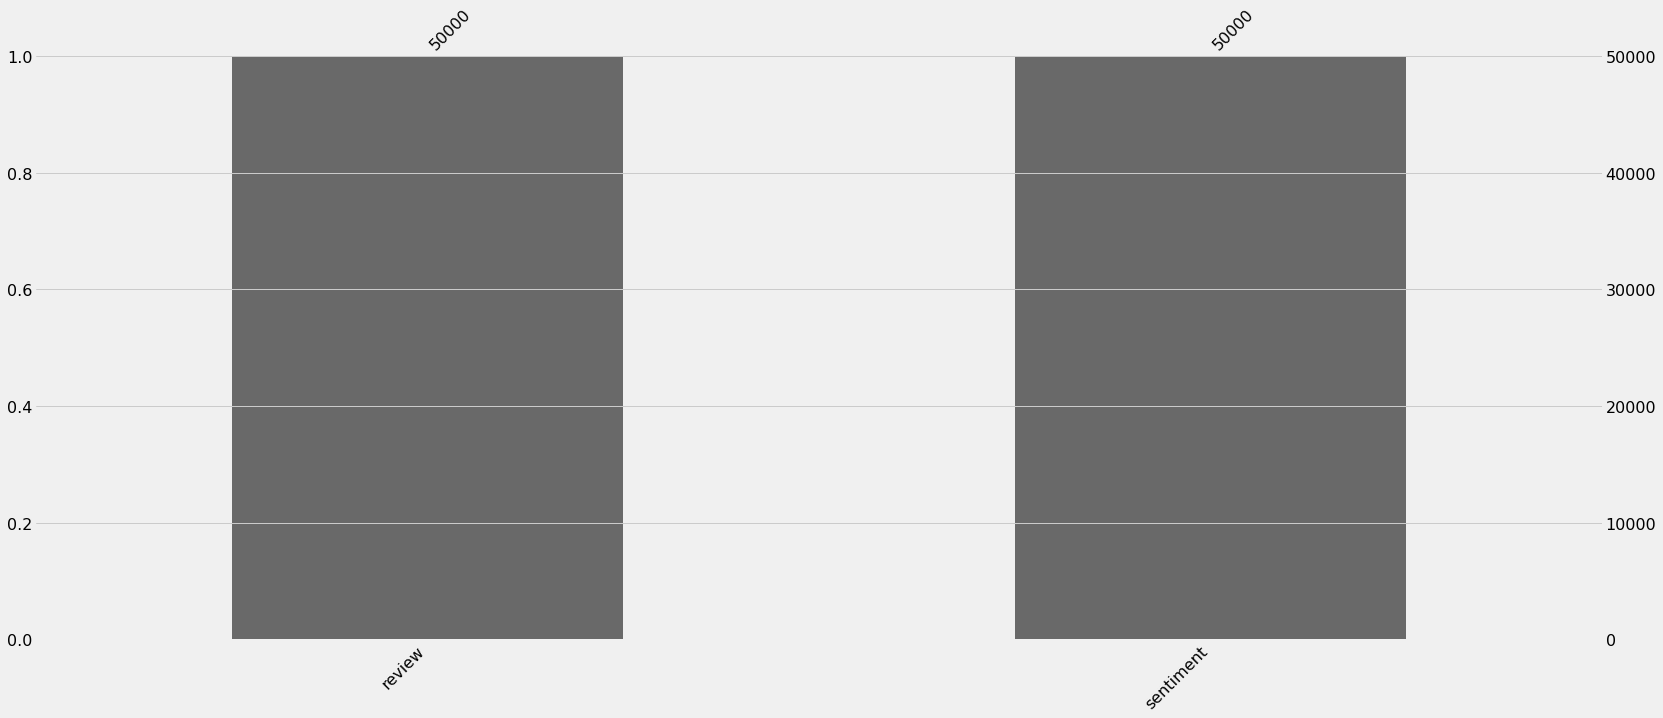

In [9]:
msno.bar(imdb_df);

**Duplicate reviews**

In [10]:
rev = imdb_df.review
duplicated_rev = imdb_df[rev.isin(rev[rev.duplicated()])].sort_values("review")
duplicated_rev

,review,sentiment
2127,"""Go Fish"" garnered Rose Troche rightly or wron...",0
31023,"""Go Fish"" garnered Rose Troche rightly or wron...",0
31286,"""Three"" is a seriously dumb shipwreck movie. M...",0
31092,"""Three"" is a seriously dumb shipwreck movie. M...",0
45271,"""Witchery"" might just be the most incoherent a...",0
...,...,...
23474,this movie sucks. did anyone notice that the e...,0
26990,"well, the writing was very sloppy, the directi...",0
21970,"well, the writing was very sloppy, the directi...",0
34761,"when I first heard about this movie, I noticed...",1


There are **824** duplicated reviews. Let's drop them.

In [11]:
imdb_df = imdb_df.drop_duplicates()
imdb_df.shape

(49582, 2)

# Analyzing text statistics

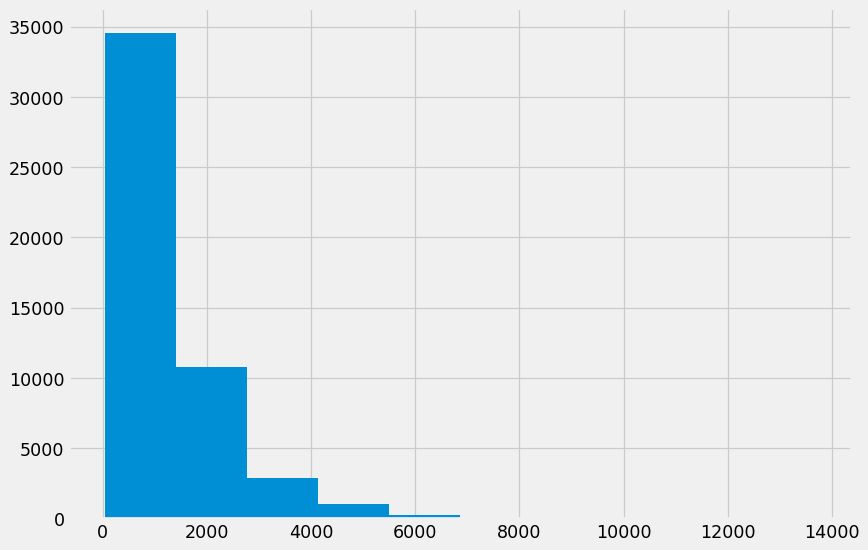

In [21]:
fig = plt.figure(figsize=(10, 7), dpi=90)
imdb_df.review.str.len().hist();

In [22]:
fig.savefig('rev_range.png',bbox_inches='tight')

The histogram shows that reviews range from 0 to 7000 characters and generally, it is between 0 to 3000 characters.

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each review.

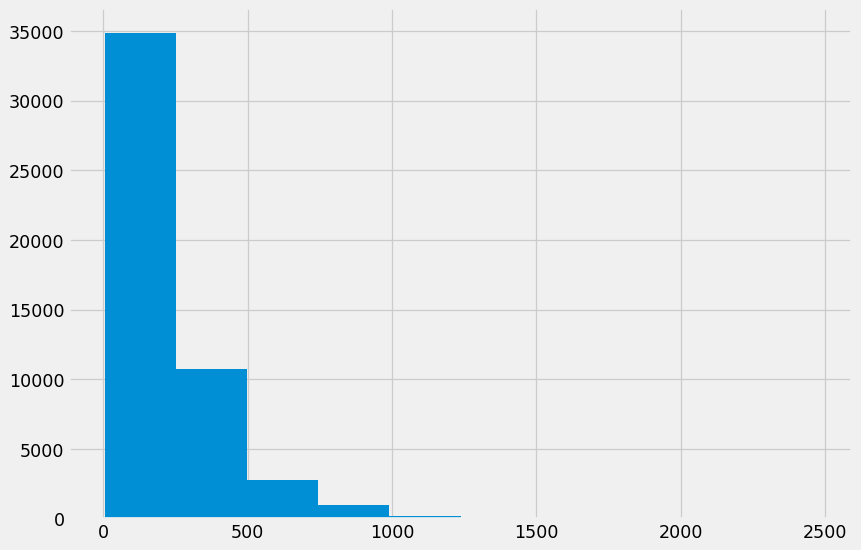

In [23]:
fig = plt.figure(figsize=(10, 7), dpi=90)
imdb_df.review.str.split().map(lambda x: len(x)).hist();

In [24]:
fig.savefig('word_level.png',bbox_inches='tight')

It is clear that the number of words in reviews ranges from 0 to 1000 and mostly falls between 0 to 500 words.

Let’s check the average word length in each sentence.

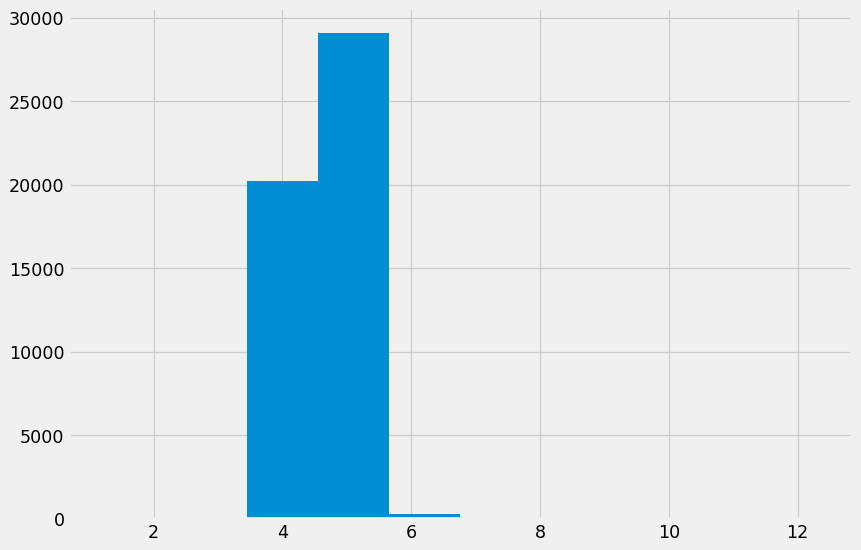

In [26]:
fig = plt.figure(figsize=(10, 7), dpi=90)

(
    imdb_df.review.str.split().apply(lambda x : [len(i) for i in x])
    .map(lambda x: np.mean(x))
    .hist()
);

In [27]:
fig.savefig('avg_word_lth.png',bbox_inches='tight')

The average word length ranges between 4 to 7 with 5 being the most common length. Does it mean that people are using really short words in reviews? Let’s find out.

One reason why this may not be true is stopwords. Stopwords are the words that are most commonly used in any language such as "the", "a", "an" etc. As these words are probably small in length these words may have caused the above graph to be left-skewed.

Analyzing the amount and the types of stopwords can give us some good insights into the data.

To get the corpus containing stopwords you can use the nltk library.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


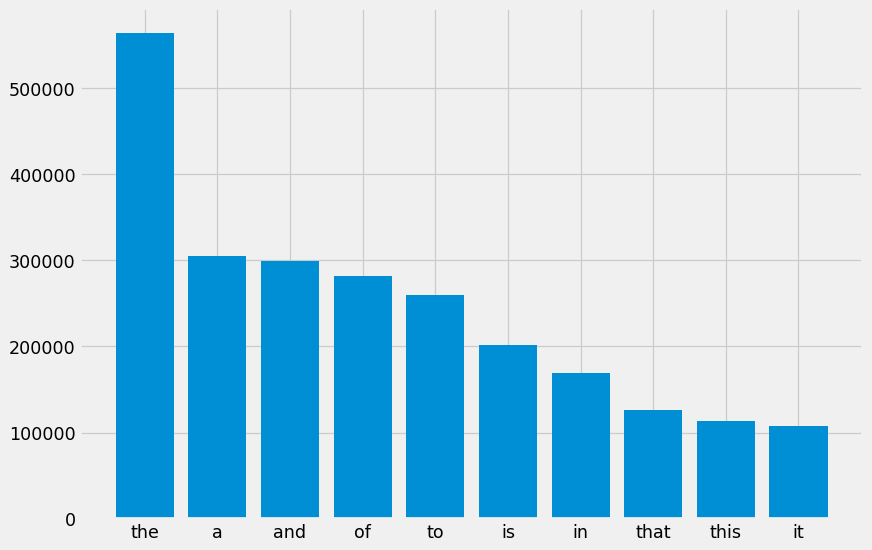

In [28]:
import nltk
from nltk.corpus import stopwords
from collections import defaultdict

nltk.download('stopwords')
stop=set(stopwords.words('english'))

corpus=[]
rev= imdb_df.review.str.split()
rev = rev.values.tolist()
corpus=[word for i in rev for word in i]

dic=defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
fig = plt.figure(figsize=(10, 7), dpi=90)
plt.bar(x,y);

In [29]:
fig.savefig('dominate_rev.png',bbox_inches='tight')

We can evidently see that stopwords such as "the", "a" and "and" dominate in reviews.

So now we know which stopwords occur frequently in our text, let’s inspect which words other than these stopwords occur frequently.


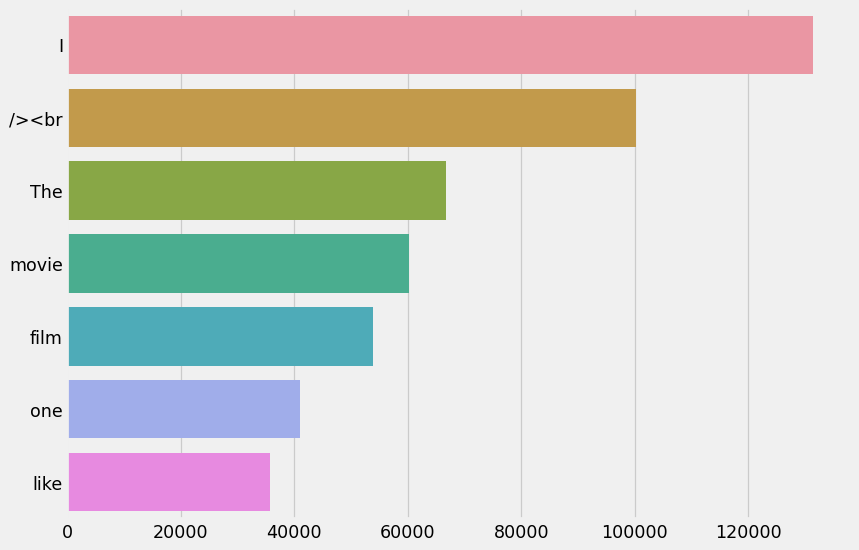

In [30]:
from collections import  Counter


counter = Counter(corpus)
most = counter.most_common()

x, y= [], []

for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

fig = plt.figure(figsize=(10, 7), dpi=90)
sns.barplot(x=y,y=x);

In [31]:
fig.savefig('NonStopw_dominate_rev.png',bbox_inches='tight')

# Ngram exploration

Ngrams are simply contiguous sequences of n words. For example "movies", "The best movie" etc.If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.

Looking at most frequent n-grams can give us a better understanding of the context in which the word was used.



To build a representation of our vocabulary we will use `Countvectorizer`.`Countvectorizer` is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form. It is available in [`sklearn.feature_engineering.text`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

Analyze the top bigrams in our reviews.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer


def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    rev = text.str.split()
    rev = rev.values.tolist()
    corpus = [word for i in rev for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    fig = plt.figure(figsize=(10, 7), dpi=90)
    sns.barplot(x=y,y=x);
    fig.savefig(f'{n}gram.png',bbox_inches='tight')

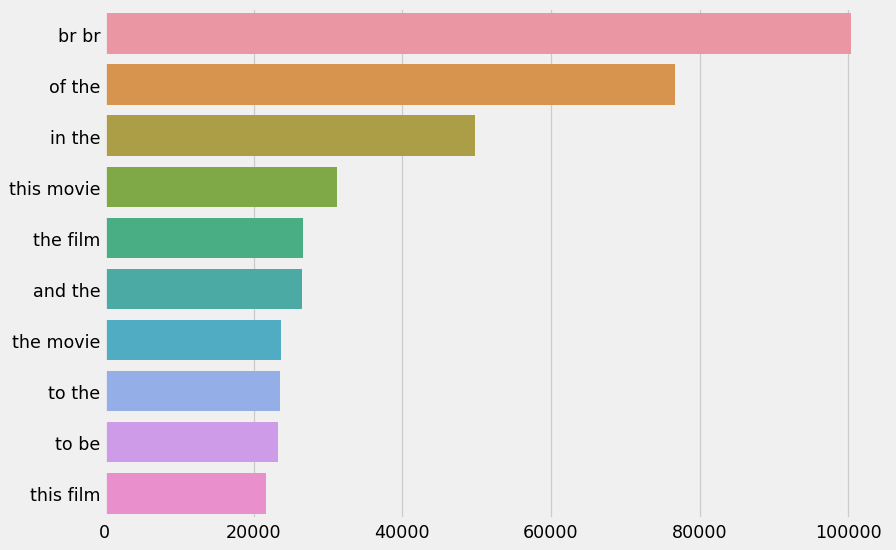

In [43]:
plot_top_ngrams_barchart(imdb_df["review"],2)

We can observe that the bigrams such as "look like", "ever seen" that are related to movies dominate the reviews.

How about trigrams?

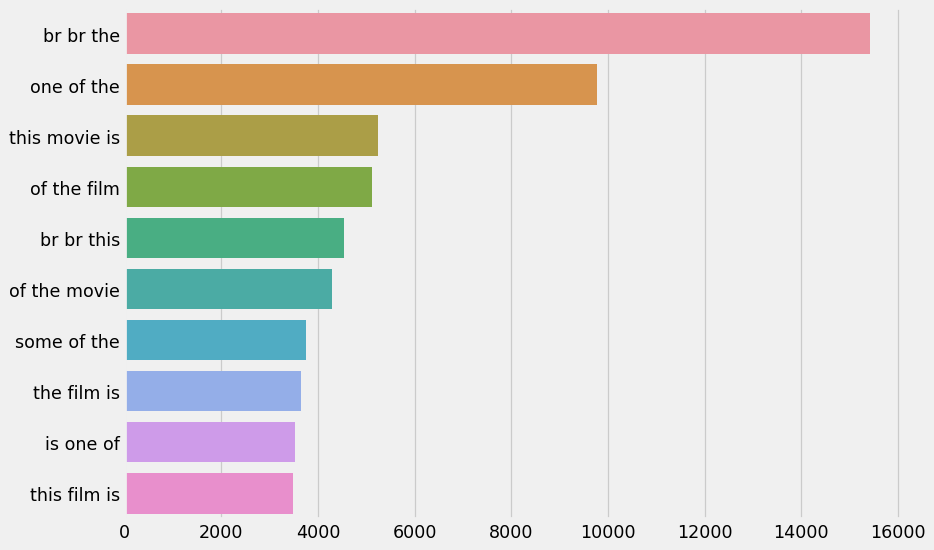

In [44]:
plot_top_ngrams_barchart(imdb_df["review"],3)

# Topic modeling exploration

Before getting into topic modeling we have to pre-process the data a little. I will:

  * tokenize: the process by which sentences are converted to a list of tokens or words.
  * remove stopwords
  * lemmatize: reduces the inflectional forms of each word into a common base or root.
  * convert to the bag of words: Bag of words is a dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus.

In [13]:
!pip install pyLDAvis --quiet

In [14]:
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models


def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

In [16]:
nltk.download('punkt')

lda_model, bow_corpus, dic = get_lda_objects(imdb_df["review"])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
lda_model.show_topics()

[(0,
  '0.032*"movie" + 0.020*"n\'t" + 0.014*"The" + 0.013*"film" + 0.011*"like" + 0.010*"one" + 0.007*"good" + 0.007*"really" + 0.007*"This" + 0.006*"would"'),
 (1,
  '0.021*"film" + 0.013*"The" + 0.007*"one" + 0.006*"character" + 0.005*"story" + 0.004*"performance" + 0.004*"time" + 0.003*"This" + 0.003*"scene" + 0.003*"n\'t"'),
 (2,
  '0.015*"The" + 0.010*"film" + 0.006*"one" + 0.004*"n\'t" + 0.003*"get" + 0.003*"scene" + 0.003*"horror" + 0.003*"like" + 0.003*"also" + 0.002*"look"'),
 (3,
  '0.011*"The" + 0.008*"show" + 0.006*"film" + 0.006*"life" + 0.006*"movie" + 0.005*"one" + 0.005*"people" + 0.004*"This" + 0.004*"would" + 0.004*"time"')]

In [18]:
plot_lda_vis(lda_model, bow_corpus, dic)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.040571  0.127566       1        1  43.013283
1      0.020965 -0.040683       2        1  26.499024
2     -0.100392 -0.074659       3        1  17.327319
3      0.119999 -0.012224       4        1  13.160375, topic_info=       Term          Freq         Total Category  logprob  loglift
135   movie  96260.000000  96260.000000  Default  30.0000  30.0000
398    show  15433.000000  15433.000000  Default  29.0000  29.0000
645    life  12889.000000  12889.000000  Default  28.0000  28.0000
550     bad  16481.000000  16481.000000  Default  27.0000  27.0000
137     n't  63596.000000  63596.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
137     n't   2434.972116  63596.240332   Topic4  -5.8084  -1.2347
584  series   1368.192751   5801.593931   Topic4  -6.3849   0.5833
49      get   1626.101141  23053.255660   Topic4  -6.2122  -0.6237
31     come   1447.682401  10155.413899   Topic4  -6.3284   0.0799
106     But   1442.728450  13590.986448   Topic4  -6.3318  -0.2149

[408 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
155       1  0.846238    've
155       2  0.090625    've
155       3  0.033129    've
155       4  0.030007    've
156       1  0.887887    ...
...     ...       ...    ...
264       4  0.202272   year
1027      1  0.134474  young
1027      2  0.467490  young
1027      3  0.175851  young
1027      4  0.222233  young

[862 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

# Wordcloud

Wordcloud is a great way to represent text data. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

In [45]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for rev in text:
            words=[w for w in word_tokenize(rev) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12), dpi=85)
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()
    fig.savefig('wordcloud.png',bbox_inches='tight')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


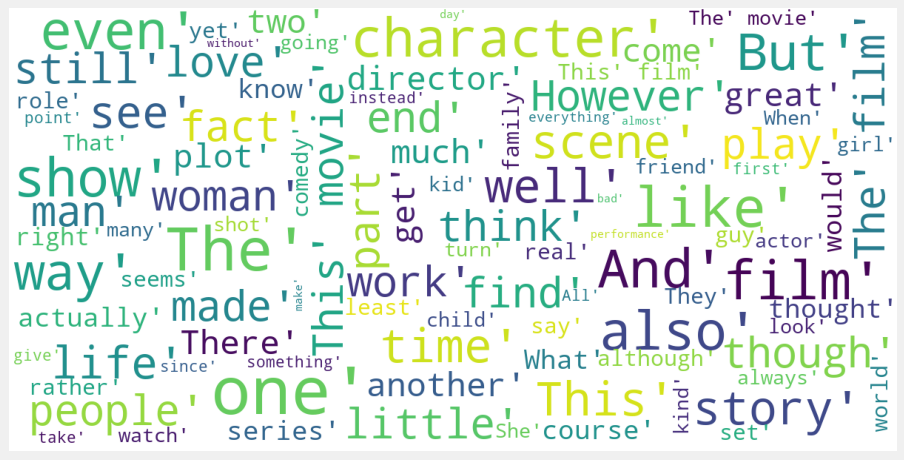

In [46]:
plot_wordcloud(imdb_df["review"])

# Cleaning the dataset

In [43]:
import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop = stopwords.words('english')
wl = WordNetLemmatizer()



# Function to clean reviews.
def wrangling(sent):
    """ 
       Return a cleaned sentences
    """
    # Remove HTML markup
    sent = re.sub('<[^>]*>', '', sent)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           sent)
    # Remove any non-word character and append the emoticons,
    # removing the noise character for standarization. Convert to lower case
    sent = (re.sub('[\W]+', ' ', sent.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return sent

# Function for removing special characters
def remove_sc(t):
  """
    Remove all characters that aren't alphanumeric or space
  """
  pattern = r'[^a-zA-z0-9\s]'
  t = re.sub(pattern,'',t)
  return t

# Function to clean data
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

def clean_reviews(text,lemmatize=True):
  """
  """
  #remove html tags
  soup = BeautifulSoup(text, "html.parser")
  text = soup.get_text()
  #expanding chatwords and contracts clearing contractions
  text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) 
  emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_clean.sub(r'',text)
  text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
  text = re.sub(r'http\S+', '', text) #remove urls
  #remove punctuation
  text = "".join([word.lower() for word in text if word not in string.punctuation]) 
  #tokens = re.split('\W+', text) #create tokens
  if lemmatize:
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
  else:
    text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Get clean data

In [44]:
clean_df = imdb_df.copy()

clean_df["review"] = (
    clean_df["review"].apply(wrangling)
    .apply(remove_sc)
    .apply(clean_reviews)
)

In [46]:
clean_df.sample(5)

,review,sentiment
33450,victor mature barely civilized mostly control ...,1
29506,oscar nominated turn secret lie brenda blethyn...,1
27903,think people give movie much credit deserves l...,1
49398,say one redeeming speck regard film firmly est...,0
29876,emma thompson alan rickman carla gugino gil be...,1


In [47]:
print(clean_df.review[15])

well first like say back retirement writing well deserved comment horrible movie movie titled scarecrow gone wild could bring back said like start comment ouch movie really horrible mean know going bad idea would spending minute possible minute film laughing thought horror movie let start biggest flaw film ken shamrock memory serf correctly shamrock one world dangerous men memory serf also stupid movie stupid comic relief looked mean else explain line time favorite line called movie long time coming ok funnest thing line five minute prior say sitting beach talking soon dead kid dam scarecrow could killed knowledge earth would start trying combat soon see scarecrow like said must comic relief except think ufc buddy laughing finished well deserved paragraph movie admit remember lot scene good considering watch movie fifteen minute ago going list top five thing wrong film usually horror movie monster theme music heard victim even monster every person involved movie able pathetic whistling

## Save clean data

In [48]:
clean_df.to_csv("./clean_imdb.csv", index=False)
print("done")

done


In [51]:
imdb_df = pd.read_csv("./clean_imdb.csv")
print(imdb_df.shape)
imdb_df.sample(10)

(49582, 2)


,review,sentiment
41429,cia codename alexa absolute horrible rip luc b...,0
16434,begin amitabh son played akshaye khanna amitab...,0
13771,buddy holly story open shot yellow neon moon r...,1
43391,gangster genre worn subject one often subjecte...,1
35637,black scorpion roger cormen batman cool lot co...,1
22214,morocco completely invaded european american b...,1
31602,documentary came across chance uk tv channel s...,1
27652,seeing film felt sick stomach seen one minute ...,0
14504,night decided watch tale hollywood hill natica...,0
27226,footprint became aware one purely accident men...,1
